In [9]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import powerlaw_sequence
from networkx.algorithms.dag import dag_longest_path

To be discussed

1. Deal with not connected components
2. Deal with cyclic graph
3. Start from root

# 1.Generate graph by Configuration Model

Generate a degree sequence with **nodeN** nodes, and **meanDegree**



In [10]:
nodeN = 10000

In [11]:
# Generate degree sequence
sequence = np.random.poisson(2, nodeN)
# sequence = nx.random_powerlaw_tree_sequence(nodeN, tries=5000)

# Generate Graph according to the degree sequence
G = nx.configuration_model(sequence)

# Remove parallel edges
G = nx.Graph(G)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

Generated Graph

**Notice:** Generated grapsh might have **cycles** and **not** connected

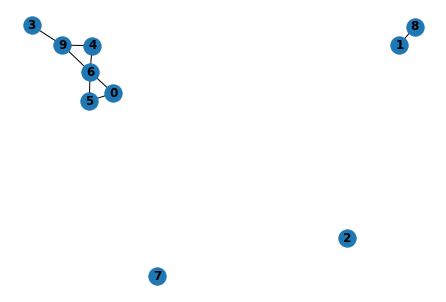

In [6]:
nx.draw(G, with_labels=True, font_weight='bold')

# 2. Decide nodes' mask wearing states

## P(A person wears a mask) = m

In [38]:
m = 0.6

Generate the mask wearing states of each node.

In [39]:
# A list of 1 and 0 indicating mask wearing or not
# 1 means wear mask, 0 means not wearing a mask
masks = np.random.binomial(1, m, nodeN)

# Node idx
nodes = np.linspace(0, nodeN - 1, nodeN, dtype = int)
# Dict of node attributes
mask_dict = dict(zip(nodes, masks))

# Set nodes attributes
nx.set_node_attributes(G, mask_dict, 'mask')

Check nodes's mask wearing states

In [40]:
masks

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1])

# 3. Init nodes infection states to all 0 (not infected)

In [41]:
# Init all nodes to be healthy
infected = np.zeros(nodeN, dtype = int)

# Node idx
nodes = np.linspace(0, nodeN - 1, nodeN, dtype = int)

# Dict of node attributes
infected_dict = dict(zip(nodes, infected))

# Set nodes attributes
nx.set_node_attributes(G, infected_dict, 'infected')

Check nodes' infected attributes

In [42]:
infected

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# 3. Generate the tree structures for each components
Get all the connected components

In [43]:
components = list(nx.connected_components(G))
# print([len(c) for c in components])

Randomly select roots for trees

In [44]:
# Roots stores the randomly selected root for each components
roots = []
# biggest_component_size = max(len(c) for c in components)
# problem_components = [c for c in components if len(c) != biggest_component_size]
for component in components:
    roots.append(random.choice(list(component)))

In [45]:
roots

[0, 8]

Convert the components to a tree-like structure, with randomly selected roots

# BFS

In [46]:
# Trees stores all the tree-structured components
Trees = []
for root in roots:
    T = nx.dfs_tree(G, source = root)
    nx.set_node_attributes(T, mask_dict, 'mask')
    nx.set_node_attributes(T, infected_dict, 'infected')
    Trees.append(T)

Look at the tree-like graphs

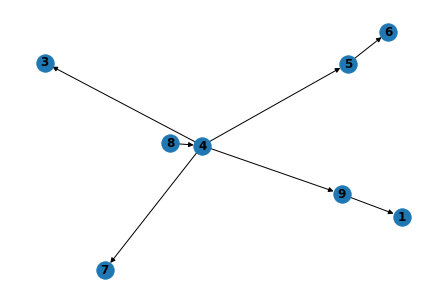

In [48]:
nx.draw(Trees[1], with_labels=True, font_weight='bold')

# 3. Starting the infection process with 1 virus strain 

**Notice**
Infection starts from root to the leaves

| Infectious    |  Susceptible   | Transmissibillity     | Notation |
| :------------- | :----------: | :----------- | :----------- |
| 1             | 0              | T * T_mask^2 * m      | T_1 |
| 1             | 1              | T * T_mask * (1 - m)  | T_2 |
| 0             | 0              | T * (1 - m)           | T_3 |
| 0             | 1              | T * T_mask * m        | T_4 |




Parameters setup

In [49]:
T_mask = 0.1
T = 0.8
# Round T to roundN digits
roundN = 5

In [50]:
T1 = round(T * T_mask * T_mask * m, roundN)
T2 = round(T * T_mask * (1 - m), roundN)
T3 = round(T * (1 - m), roundN)
T4 = round(T * T_mask * m , roundN)

trans_dict = {'T1': T1,
              'T2': T2,
              'T3': T3,
              'T4': T4}

print("T1: %.5f" %T1)
print("T2: %.5f" %T2)
print("T3: %.5f" %T3)
print("T4: %.5f" %T4)

T1: 0.00480
T2: 0.03200
T3: 0.32000
T4: 0.04800


## Traverse from the root nodes using dfs search

Starting with 1 seed

In [51]:

for idx, tree in enumerate(Trees): 
    print("TREE No.", idx)
    
    edge_attr = dict()
    root = roots[idx]
    dfs_edges = list(nx.dfs_edges(tree, source = root))
    total_depth = nx.dag_longest_path_length(tree)
    
    nx.set_node_attributes(tree, infected_dict, 'infected')
    nx.set_node_attributes(tree, {root: 1}, 'infected') # Let root node be infected by nature

    
    for depth in range(1, total_depth + 1): # Transmitted level by level
        print('LEVEL %d' % depth)
        
        if depth == 1: # Get only this level's node pairs
            dfs_edges = list(nx.dfs_edges(tree, source = root, depth_limit = depth))
            
        else: 
            
            dfs_edges = set(nx.dfs_edges(tree, source = root, depth_limit = depth)) - \
                        set(nx.dfs_edges(tree, source = root, depth_limit = depth - 1))
        
        
        for father, son in dfs_edges: # Check each node pairs in this level
            print("(%d, %d), node %d is_infected = %d" %(father, son, father, tree.nodes[father]['infected'] ))
            
            if tree.nodes[father]['infected'] == 1: 
                
                # Decide which transmissibility
                if tree.nodes[father]['mask'] == 1 and tree.nodes[son]['mask'] == 0:
                    T_edge = 'T1'
                elif tree.nodes[father]['mask'] == 1 and tree.nodes[son]['mask'] == 1:
                    T_edge = 'T2'
                elif tree.nodes[father]['mask'] == 0 and tree.nodes[son]['mask'] == 0:
                    T_edge = 'T3'
                else:
                    T_edge = 'T4'

                edge_attr[(father,son)] = {'T': T_edge}
                
                
                # Set the 'Transmissibility'edge attrs
                nx.set_edge_attributes(tree, edge_attr)
            
            
                # Decide if the susceptible is infected
                is_infected = int(random.random() < trans_dict[T_edge])
                
                if is_infected:
                    print("node %d is infected with %s" %(son, T_edge))
                else:
                    print("node %d is not infected" %(son))
                
                
                # Set the 'infected' node attr accordingly
                nx.set_node_attributes(tree, {son: is_infected}, 'infected')


    


TREE No. 0
LEVEL 1
(0, 2), node 0 is_infected = 1
node 2 is not infected
TREE No. 1
LEVEL 1
(8, 4), node 8 is_infected = 1
node 4 is not infected
LEVEL 2
(4, 5), node 4 is_infected = 0
(4, 7), node 4 is_infected = 0
(4, 9), node 4 is_infected = 0
(4, 3), node 4 is_infected = 0
LEVEL 3
(5, 6), node 5 is_infected = 0
(9, 1), node 9 is_infected = 0


## Look at the infected result

change i to look at different sub-trees

root node: 6


{(6, 18): Text(95.8, 234.58499999999998, "{'T': 'T4'}"),
 (18, 1): Text(158.53, 196.99, "{'T': 'T1'}"),
 (18, 7): Text(111.42349999999999, 263.59000000000003, "{'T': 'T2'}"),
 (18, 9): Text(143.97, 268.67499999999995, "{'T': 'T2'}"),
 (18, 14): Text(178.27499999999998, 236.195, "{'T': 'T1'}"),
 (18, 19): Text(114.955, 191.445, "{'T': 'T1'}"),
 (14, 12): Text(258.99, 249.56, '{}'),
 (12, 5): Text(334.375, 256.47, '{}'),
 (19, 0): Text(75.9665, 119.55699999999999, '{}'),
 (0, 3): Text(42.451499999999996, 51.617, '{}')}

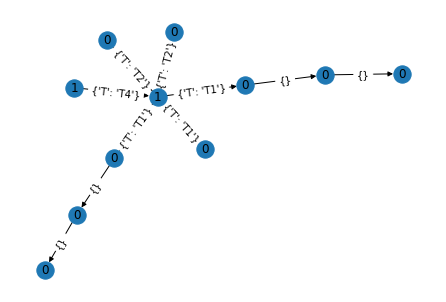

In [82]:
i = 0
pos = nx.nx_agraph.graphviz_layout(Trees[i])

nx.draw(Trees[i], pos, with_labels = False)

# # Show nodes' attrs
node_labels = nx.get_node_attributes(Trees[i],'infected')
nx.draw_networkx_labels(Trees[i], pos, labels = node_labels)
print("root node:", roots[i])
# Show edges' attrs
edge_labels = nx.get_edge_attributes(Trees[i],'T')
nx.draw_networkx_edge_labels(Trees[i], pos, labels = edge_labels)

In [83]:
E_S = []
for idx, tree  in enumerate(Trees):
    res = np.array(list(tree.nodes.data('infected')))
    print(res)
    es = sum(res[:,1]) / res.shape[0]
    E_S.append(es)
    print("Tree %d Epidemic Size: %.3f" %(idx, es))

print('Avg Epidemic Size:', sum(E_S) / len(E_S))

[[ 6  1]
 [18  1]
 [ 1  0]
 [ 7  0]
 [ 9  0]
 [14  0]
 [12  0]
 [ 5  0]
 [19  0]
 [ 0  0]
 [ 3  0]]
Tree 0 Epidemic Size: 0.182
[[ 4  1]
 [ 8  0]
 [11  0]
 [ 2  0]
 [17  0]
 [13  0]]
Tree 1 Epidemic Size: 0.167
[[16  1]
 [10  0]
 [15  0]]
Tree 2 Epidemic Size: 0.333
Avg Epidemic Size: 0.2272727272727273
